In [ ]:
# IMPORTS
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from fastai import *
from fastai.vision import *
from fastai.callback import *
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
from PIL import Image
import scipy
import sys
import time
import copy
import pickle
import sklearn.metrics
from google.colab import drive
drive.mount('/content/gdrive')
import os
import cv2

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/hackathon_2022/train'
CSV_PATH_TRAIN = "/content/gdrive/MyDrive/hackathon_2022/train/data.csv"
train_labels = pd.read_csv(CSV_PATH_TRAIN)

In [ ]:
train_labels

Unnamed: 0           img  presence_of_fracture
0              0   1001_L1.png                   1.0
1              1   1001_L2.png                   0.0
2              2   1001_L3.png                   1.0
3              3  1001_T10.png                   0.0
4              4  1001_T11.png                   0.0
...          ...           ...                   ...
1123        1123  9006_T11.png                   0.0
1124        1124  9006_T12.png                   0.0
1125        1125   9006_T7.png                   0.0
1126        1126   9006_T8.png                   0.0
1127        1127   9006_T9.png                   0.0

[1128 rows x 3 columns]

In [ ]:
fracture_ratio = np.sum(train_labels['presence_of_fracture'].values == 1)/train_labels.shape[0]
train_ratio = 0.80
val_ratio = 0.20
random.seed(12)
fract_tol = 0.1
keep_splitting = True
while keep_splitting:
  val_indicies = random.sample(list(range(train_labels.shape[0])), int(val_ratio * train_labels.shape[0]))
  val_fract_ratio = np.sum(train_labels.loc[val_indicies,'presence_of_fracture'] == 1)/len(val_indicies)
  if abs(val_fract_ratio - fracture_ratio) < fract_tol:
    keep_splitting = False
train_labels['Set'] = 0
train_labels.loc[val_indicies, 'Set'] = 1

In [ ]:
# For EfficientNet-B0
# resized_image_length = 224

# No noise transform because the images are already pretty low quality/noisy
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(10, expand=True),
    transforms.Resize((224, 224)),
    transforms.Normalize((.485, .456, .406), (.229, .224, .225))
    ])

normalize_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.Normalize((.485, .456, .406),(.229, .224, .225))])


In [ ]:
def standardize_image(img):
    standardized_img = (img - np.min(img))/(np.max(img) - np.min(img))
    return standardized_img

def read_image(fname,crop_side_dim):
  img = Image.open(f"{PATH}/{fname}")
  if len(np.array(img).shape) > 2:
    img = img.convert('L')
  img = np.array(img)
  img = scipy.ndimage.zoom(img,crop_side_dim/img.shape[0],order = 3)
  return img

batch_size  = 5
num_workers = 0
class Data(Dataset):
    def __init__(self, labels_df, set_name,transforms = None,
        resized_image_length = 224):
        
        if set_name == 'train':
            self.labels_df = labels_df.loc[labels_df.Set == 0, :]
        elif set_name == 'val':
            self.labels_df = labels_df.loc[labels_df.Set == 1, :]
        else:
            print("Wrong set name was given")

        self.images     = list(self.labels_df['img'])
        self.labels     = list(self.labels_df['presence_of_fracture'])
        self.len        = len(self.labels)
        self.transforms = transforms
        self.resized_image_length = resized_image_length

    def __getitem__(self, index):
        image_path = self.images[index]
        label      = self.labels[index]
        image      = read_image(image_path,self.resized_image_length)

        # Normalize the image
        image = standardize_image(image)

        # Stack image 3 times for 3 input channels
        image = np.stack([image,image,image],axis = 0)
        image = image.astype(np.float64)
        image = torch.from_numpy(image)

        # Transform
        if self.transforms:
            image = self.transforms(image)

        label = torch.from_numpy(np.asarray(label))
        return image.type(torch.FloatTensor), label.type(torch.LongTensor)

    def __len__(self):
        return self.len

trainset = Data(labels_df=train_labels, set_name='train', transforms = transform)
valset   = Data(labels_df=train_labels, set_name='val', transforms = normalize_transform)
#print("Length of training set:", trainset.len)
#print("Length of validation set:", valset.len)

trainset_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers,
                             drop_last=True)

valset_loader = DataLoader(valset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers,
                             drop_last=False)

In [ ]:
"""def show_class_counts(classes, class_counts, title=None):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(classes, class_counts)
    ax.set_xticklabels(classes)
    if title is not None:
        plt.title(title)
    plt.show()

def count_normal_and_fract(df, class_names):
    class_counts   = np.zeros(len(class_names))
    labels         = np.sort(np.unique(df['presence_of_fracture'].values))

    abb_labels = [class_names[int(i)] for i in labels]
    abb_counts = [df[df['presence_of_fracture'] == i].shape[0] for i in labels]

    return abb_labels, abb_counts

training_labels, training_counts = count_normal_and_fract(train_labels[train_labels.Set == 0], ['Control','Positive'])
val_labels, val_counts = count_normal_and_fract(train_labels[train_labels.Set == 1], ['Control','Positive'])

show_class_counts(training_labels, training_counts, title='Training Class Balance')
show_class_counts(val_labels, val_counts, title='Validation Class Balance')"""

"def show_class_counts(classes, class_counts, title=None):\n    fig = plt.figure()\n    ax = fig.add_axes([0, 0, 1, 1])\n    ax.bar(classes, class_counts)\n    ax.set_xticklabels(classes)\n    if title is not None:\n        plt.title(title)\n    plt.show()\n\ndef count_normal_and_fract(df, class_names):\n    class_counts   = np.zeros(len(class_names))\n    labels         = np.sort(np.unique(df['presence_of_fracture'].values))\n\n    abb_labels = [class_names[int(i)] for i in labels]\n    abb_counts = [df[df['presence_of_fracture'] == i].shape[0] for i in labels]\n\n    return abb_labels, abb_counts\n\ntraining_labels, training_counts = count_normal_and_fract(train_labels[train_labels.Set == 0], ['Control','Positive'])\nval_labels, val_counts = count_normal_and_fract(train_labels[train_labels.Set == 1], ['Control','Positive'])\n\nshow_class_counts(training_labels, training_counts, title='Training Class Balance')\nshow_class_counts(val_labels, val_counts, title='Validation Class Balance'

In [ ]:
model = models.efficientnet_b0(pretrained=True)
model.classifier._modules['1'] = nn.Linear(in_features=1280, out_features=2, bias=True)

In [ ]:
print("GPU available: ", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Model successfully assigned to:", device)

GPU available:  True
Model successfully assigned to: cuda


In [ ]:
# Train
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25, return_stats=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    epoch_losses = {'train': [], 'val': []}
    epoch_accs = {'train': [], 'val': []}
    epoch_sens = {'train': [], 'val': []}
    epoch_specs = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_sens_corrects = 0
            running_spec_corrects = 0
            total_positives = 1e-4
            total_normals   = 1e-4

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_sens_corrects += torch.sum(preds[labels.data == 1] == labels.data[labels.data == 1])
                running_spec_corrects += torch.sum(preds[labels.data == 0] == labels.data[labels.data == 0])

                total_positives += torch.sum(labels.data == 1)
                total_normals   += torch.sum(labels.data == 0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc  = running_corrects.double() / (total_positives + total_normals)
            epoch_sen  = running_sens_corrects.double() / total_positives
            epoch_spec = running_spec_corrects.double() / total_normals

            epoch_losses[phase].append(epoch_loss)
            epoch_accs[phase].append(epoch_acc)
            epoch_sens[phase].append(epoch_sen)
            epoch_specs[phase].append(epoch_spec)

            print('{} loss: {:.4f} acc: {:.2f}% sens: {:.2f}% spec: {:.2f}%'.format(
                phase, epoch_loss, 100*epoch_acc, 100*epoch_sen, 100*epoch_spec))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('Updating best model')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        
        time_elapsed = time.time() - epoch_start
        print('Epoch time: {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    if return_stats:
        return model, epoch_losses, epoch_accs, epoch_sens, epoch_spec
    else:
        return model

In [ ]:
num_epochs = 50
lr = 0.00005
class_weights = torch.tensor([1.,500000000.]).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [ ]:
dataloaders = {'train': trainset_loader, 'val': valset_loader}
model, losses, accs, sens, spec = train_model(dataloaders, model, criterion, 
                            optimizer, scheduler, num_epochs, return_stats=True)

Epoch 1/50
----------
train loss: 0.2873 acc: 97.89% sens: 93.90% spec: 98.29%
val loss: 1.0261 acc: 91.56% sens: 95.24% spec: 91.18%
Updating best model
Epoch time: 0m 33s

Epoch 2/50
----------
train loss: 0.3894 acc: 97.33% sens: 92.68% spec: 97.80%
val loss: 1.3902 acc: 91.11% sens: 80.95% spec: 92.16%
Epoch time: 0m 33s

Epoch 3/50
----------
train loss: 0.2182 acc: 99.00% sens: 98.78% spec: 99.02%
val loss: 1.1494 acc: 91.11% sens: 90.48% spec: 91.18%
Epoch time: 0m 32s

Epoch 4/50
----------
train loss: 0.2441 acc: 99.00% sens: 95.06% spec: 99.39%
val loss: 1.1438 acc: 91.11% sens: 95.24% spec: 90.69%
Epoch time: 0m 32s

Epoch 5/50
----------
train loss: 0.3363 acc: 97.67% sens: 95.12% spec: 97.92%
val loss: 1.2646 acc: 89.78% sens: 85.71% spec: 90.20%
Epoch time: 0m 32s

Epoch 6/50
----------
train loss: 0.2007 acc: 99.11% sens: 97.53% spec: 99.27%
val loss: 1.1574 acc: 91.56% sens: 95.24% spec: 91.18%
Epoch time: 0m 31s

Epoch 7/50
----------
train loss: 0.2659 acc: 98.44% sen

In [ ]:
# Save Path
save_path = '/content/gdrive/MyDrive/Hackathon_models/#3_06232002_VertibralFractureDetection'
torch.save(model.state_dict(), save_path)

# Stats Save Path
stats = {'losses': losses, 'accs': accs, 'sens': sens, 'spec': spec}

with open('/content/gdrive/MyDrive/Hackathon_models/#3_06232002_VertibralFractureDetection.pkl', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load model
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Hackathon_models/#3_06232002_VertibralFractureDetection'))
model.eval()

# Load stats
with open('/content/gdrive/MyDrive/Hackathon_models/#3_06232002_VertibralFractureDetection.pkl', 'rb') as handle:
    stats = pickle.load(handle)
losses = stats['losses']
accs  = stats['accs']

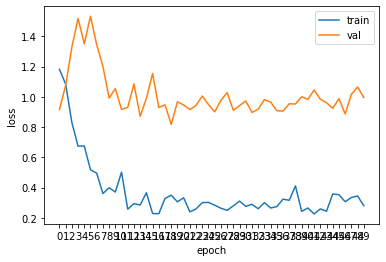

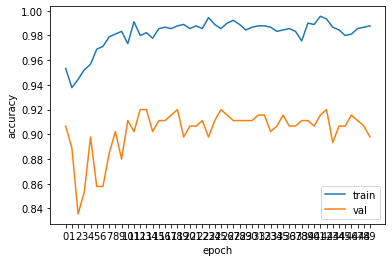

In [ ]:
# Plot loss per epoch
plt.figure()
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(losses['train'])))
plt.ylabel('loss')
plt.legend(['train', 'val'])

# Plot accuracy per epoch
accs_train = [k.cpu() for k in accs['train']]
accs_val = [k.cpu() for k in accs['val']]
plt.figure()
plt.plot(accs_train)
plt.plot(accs_val)
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(accs['train'])))
plt.ylabel('accuracy')
plt.legend(['train', 'val'])

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [ ]:
def test_metrics(dataloader, model):
    sm = torch.nn.Softmax(dim = 1)
    correct = 0
    total = 0

    correct_pos = 0
    correct_neg = 0
    true_pos = 0
    true_neg = 0

    all_pred_logits = torch.zeros(0)
    all_labels = torch.zeros(0)

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            all_pred_logits = torch.cat((all_pred_logits,sm(outputs)[:,1].cpu()),dim = 0)
            all_labels = torch.cat((all_labels,labels.cpu()),dim = 0)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            true_pos += (labels == 1).sum().item()
            true_neg += (labels == 0).sum().item()

            correct_pos += (predicted[labels == 1] == labels[labels == 1]).sum().item()
            correct_neg += (predicted[labels == 0] == labels[labels == 0]).sum().item()
            correct += (predicted == labels).sum().item()

    return 100 * correct / total, 100 * correct_pos / true_pos, 100 * correct_neg / true_neg, all_pred_logits, all_labels

overall_acc, overall_sens, overall_spec, preds, labels = test_metrics(valset_loader, model)

print('Accuracy of the network on the test images: %d %%' % overall_acc)
print('Sensitivity of the network on the test images: %d %%' % overall_sens)
print('Specificity of the network on the test images: %d %%' % overall_spec)

Accuracy of the network on the test images: 92 %
Sensitivity of the network on the test images: 90 %
Specificity of the network on the test images: 92 %


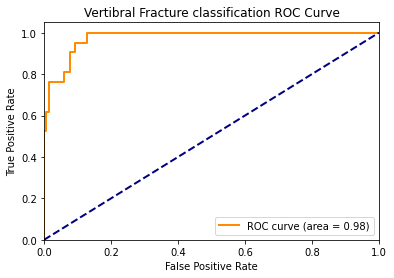

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(labels.numpy(), preds.numpy(), pos_label = 1)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Vertibral Fracture classification ROC Curve')
plt.legend(loc="lower right")
plt.show()